# Predicting bitcoin value 

based on this https://towardsdatascience.com/predicting-prices-of-bitcoin-with-machine-learning-3e83bb4dd35f

In [29]:
pip install tdqm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook as tqdm
import itertools

In [3]:
bc_data = pd.read_csv('BTC-USD.csv')

bc_data['Date'] = pd.to_datetime(bc_data.Date)

# Setting the index as the date
bc_data.set_index('Date', inplace=True)

# Taking the last two years closing values (almost)
bc_data = bc_data[['Close']].loc['2019-09-01':]


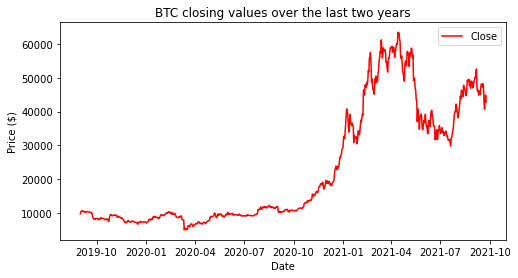

In [4]:
# Plotting closing price of BTC 
plt.close('all')
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(bc_data, color='red', label='Close')
ax.set_title('BTC closing values over the last two years')
ax.set_xlabel('Date')
ax.set_ylabel(r"Price (\$)")
ax.legend()
plt.show()

## Making the data stationary by differencing

In [184]:
# Using log values here (to get lower p-values)
bc_log = pd.DataFrame(np.log(bc_data.Close))

# Differencing the log values
diff_log = bc_log.diff().dropna()

# Using the Dickey-Fuller test to check for stationarity
results = adfuller(diff_log.Close)
print(f"P-value: {results[1]}")


P-value: 2.2742075973714102e-23


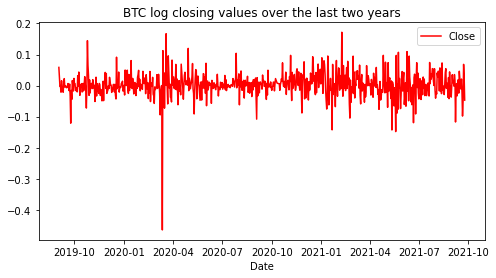

In [7]:
# Plotting the differencing log close values of btc
plt.close('all')
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(diff_log, color='red', label='Close')
ax.set_title('BTC log closing values over the last two years')
ax.set_xlabel('Date')
ax.legend()
plt.show()

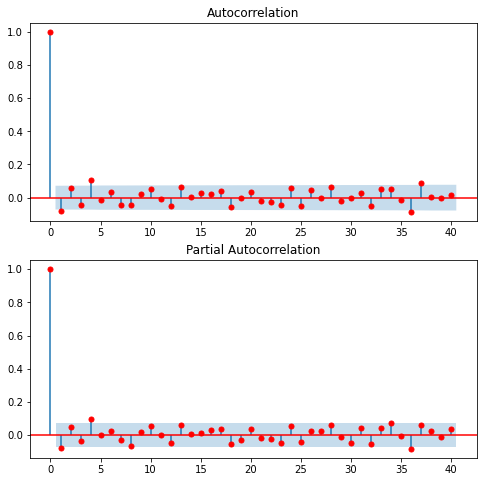

In [8]:
# Plotting autocorrelation
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(diff_log, ax = axs[0], alpha=0.05, color='red', label='ACF', lags=40)
plot_pacf(diff_log, ax = axs[1], color='red', label='PACF', lags=40)
plt.show()

Not highly correlated

# SARIMA Modeling

SARIMA stands for Seasonal Autoregressive Integrated Moving Average. "It is an extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA.
Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series." (https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)

In [19]:
# create a set of SARIMA configs to try
def sarima_parameters(seasonal=[0]):
    order = []
    seasonal_order = []
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    #t_params = ['n','c','t','ct'] # Trend parameters 
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                #for t in t_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                order.append((p,d,q)) 
                                seasonal_order.append((P,D,Q,m))
    return order, seasonal_order

In [20]:
# Better solutions to get every possible configuration of order and seasonal orders:

# Assigning variables for p, d, q. (Those parameters model the trend)
p = d = q = range(0,2)

# Creating a list of all possible combinations of p, d, and q. 
pdq = list(itertools.product(p, d, q))

# Model the seasonality with the hyperparameters p, d, q & s
s = [12] # twelve months
pdqs = list(itertools.product(p, d, q, s))

In [21]:
def best_param(model, data, pdq, pdqs):
    """
    Loops through each possible combo for pdq and pdqs
    Runs the model for each combo
    Retrieves the model with lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            freq='D')

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

In [105]:
# Find sarima parameters
order, seasonal_order = sarima_parameters()

# Use previous hyperparameters to find the best model (lowest AIC here)
out_df = best_param(SARIMAX, bc_log.Close, pdq, pdqs)

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/pytho

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_en

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3

In [106]:
print(out_df)

pdq         (1, 1, 0)
pdqs    (0, 0, 0, 12)
aic      -2676.674775
Name: 48, dtype: object


### We have found the best hyperparameteres for our sarimax model
Now we can train the model with 80% of our data

In [182]:
idx_80 = round(0.8 * len(bc_log))

# Training and test set (80/20%)
train_set = bc_log.iloc[:idx_80]
test_set = bc_log.iloc[idx_80:]

model1 = SARIMAX(train_set,
                 order=out_df.pdq,
                 seasonal_order=out_df.pdqs,
                 trend=[1,1,2,0] , 
                 enforce_stationarity=True, 
                 enforce_invertibility=False)
model2 = SARIMAX(train_set,
                 order=out_df.pdq,
                 seasonal_order=out_df.pdqs,
                 trend=[3,1,4,1], 
                 enforce_stationarity=True, 
                 enforce_invertibility=False)
model3 = SARIMAX(train_set,
                 order=out_df.pdq,
                 seasonal_order=out_df.pdqs,
                 freq='D', 
                 enforce_stationarity=False, 
                 enforce_invertibility=False)
output1 = model.fit()
output2 = model2.fit()
output3 = model3.fit()

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3

Model 1
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  756
Model:               SARIMAX(1, 1, 0)   Log Likelihood                1343.701
Date:                Sun, 10 Oct 2021   AIC                          -2675.402
Time:                        16:52:29   BIC                          -2647.649
Sample:                    09-01-2019   HQIC                         -2664.711
                         - 09-25-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0048   3.35e-07  -1.44e+04      0.000      -0.005      -0.005
drift       3.029e-05   3.56e-05      0.851      0.395   -3.95e-05       0.000
trend.2      2.05e-08   1.42e-07      0.144 

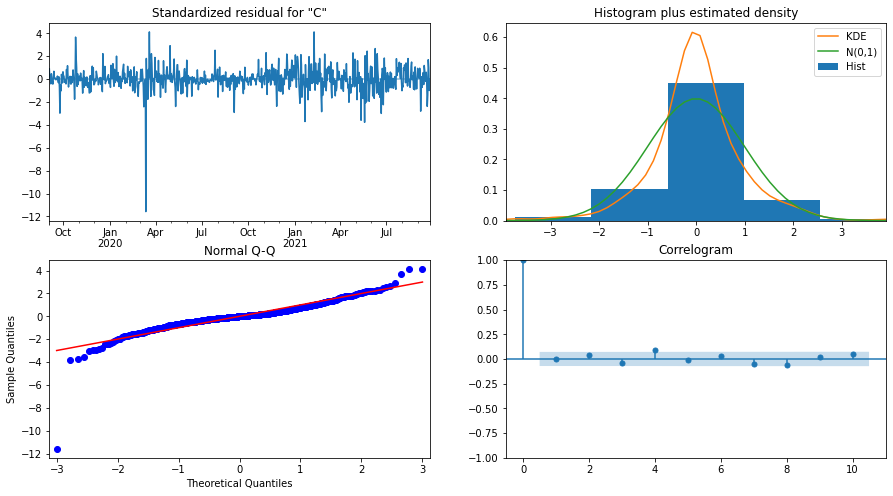

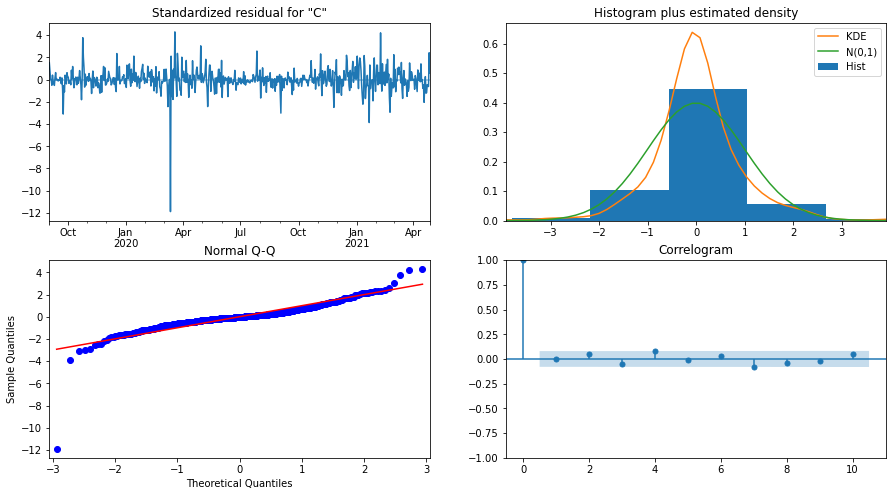


 Model 3
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  605
Model:               SARIMAX(1, 1, 0)   Log Likelihood                1093.517
Date:                Sun, 10 Oct 2021   AIC                          -2175.033
Time:                        16:52:31   BIC                          -2148.612
Sample:                    09-01-2019   HQIC                         -2164.751
                         - 04-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0011   5.74e-07  -1883.875      0.000      -0.001      -0.001
drift      -4.722e-05   4.98e-05     -0.948      0.343      -0.000    5.04e-05
trend.2     3.425e-07   2.67e-07      1.28

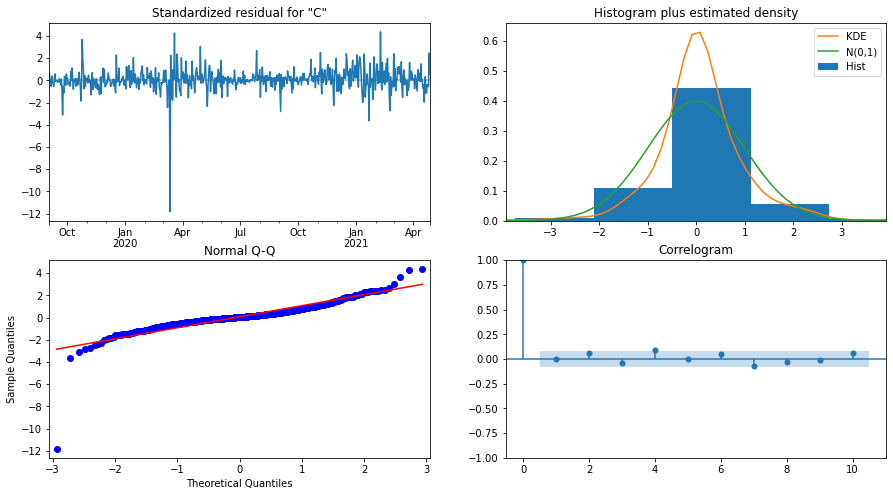

In [183]:
print('Model 1')
print(output1.summary())
output1.plot_diagnostics(figsize=(15,8))
plt.show()

print('\n Model 2')
print(output2.summary())
output2.plot_diagnostics(figsize=(15,8))
plt.show()

print('\n Model 3')
print(output2.summary())
output3.plot_diagnostics(figsize=(15,8))
plt.show()

In [181]:
# Values to test against the test set
test_set = pd.DataFrame(test_set.dropna())
forecast_3   = output3.get_forecast(len(test_set))
forecast_1   = output1.get_forecast(len(test_set))
forecast_2   = output2.get_forecast(len(test_set))


conf = forecast_2.conf_int()

# Our data was in log
forecast_series3 = np.exp(pd.Series(forecast_3.predicted_mean, 
                                    index=test_set.index))
forecast_series2 = np.exp(pd.Series(forecast_2.predicted_mean, 
                                    index=test_set.index))
forecast_series1 = np.exp(pd.Series(forecast_1.predicted_mean, 
                                    index=test_set.index))

conf_lower = np.exp(pd.Series(conf.iloc[:, 0], 
                              index=test_set.index)) # Retrieve first column
conf_upper = np.exp(pd.Series(conf.iloc[:, 1], 
                              index=test_set.index))

# Transform test and training set 
test_set_exp = np.exp(test_set)
train_set_exp = np.exp(train_set)

# predictions from the three models
predictions_1 = output1.get_prediction(start=pd.to_datetime('2019-09-01'), 
                                       dynamic=False)
predict_1_exp = np.exp(predictions_1.predicted_mean)

predictions_2 = output2.get_prediction(start=pd.to_datetime('2019-09-01'), 
                                       dynamic=False)
predict_2_exp = np.exp(predictions_2.predicted_mean)

predictions_3 = output3.get_prediction(start=pd.to_datetime('2019-09-01'), 
                                       dynamic=False)
predict_3_exp = np.exp(predictions_3.predicted_mean)

# Confidence interval for the training set
conf_int1   = np.exp(predictions_1.conf_int())
low_conf   = np.exp(pd.Series(conf_int1.iloc[:,0], 
                              index=train_set.index))
upper_conf = np.exp(pd.Series(conf_int1.iloc[:,1], 
                              index=train_set.index))

conf_int2   = np.exp(predictions_2.conf_int())
low_conf   = np.exp(pd.Series(conf_int2.iloc[:,0], 
                              index=train_set.index))
upper_conf = np.exp(pd.Series(conf_int2.iloc[:,1], 
                              index=train_set.index))

conf_int3   = np.exp(predictions_3.conf_int())
low_conf   = np.exp(pd.Series(conf_int3.iloc[:,0], 
                              index=train_set.index))
upper_conf = np.exp(pd.Series(conf_int3.iloc[:,1], 
                              index=train_set.index))

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


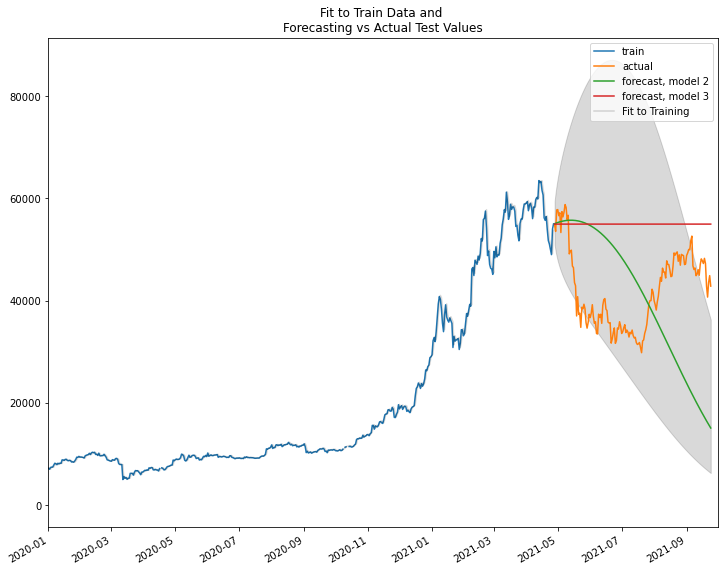

In [134]:
plt.close('all')
plt.figure(figsize=(12,10))
# Plotting the training set, test set,forecast, and confidence interval.
plt.plot(train_set_exp, label='train')
plt.plot(test_set_exp, label='actual')
#plt.plot(forecast_series1, label='forecast, model 1')
plt.plot(forecast_series2, label='forecast, model 2')
plt.plot(forecast_series3, label='forecast, model 3')


plt.fill_between(conf_lower.index, conf_lower, conf_upper, color='k', alpha=.15)

# Plotting against the training data
predict_2_exp.plot(label='Fit to Training, model 2', color='k', alpha=0.15)
#predict_1_exp.plot(label='Fit to Training', color='w', alpha=0.15)
#predict_3_exp.plot(label='Fit to Training, model 3', color='r', alpha=0.15)



# Confidence interval for the fitted data
plt.fill_between(conf_int1.index, conf_int1.iloc[:,0], conf_int1.iloc[:,1], color='g',alpha=.5)

# Limiting the viewing size
plt.xlim(['2020-01', '2021-10'])

plt.title('Fit to Train Data and \nForecasting vs Actual Test Values')
plt.legend()
plt.savefig('btc_fit_fc.png')
plt.show()

In [147]:
forecast = predict_2_exp
actual_val = train_set_exp.Close

# Calculating our errors
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

The Root Mean Squared Error:  1031.3483515952564


# Forecasting Future Values


In [176]:
model = SARIMAX(bc_log, 
                order=out_df.pdq, 
                seasonal_order=out_df.pdqs, 
                trend=[3,1,4,1], 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/alexisruiz/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [179]:
# Getting the forecast of future values
forecast_values = output.get_forecast(steps=50)

# Transforming values back
pred_fut = np.exp(forecast_values.predicted_mean)

# Confidence interval for our forecasted values
pred_conf = forecast_values.conf_int()

# Transforming value back
pred_conf = np.exp(pred_conf)

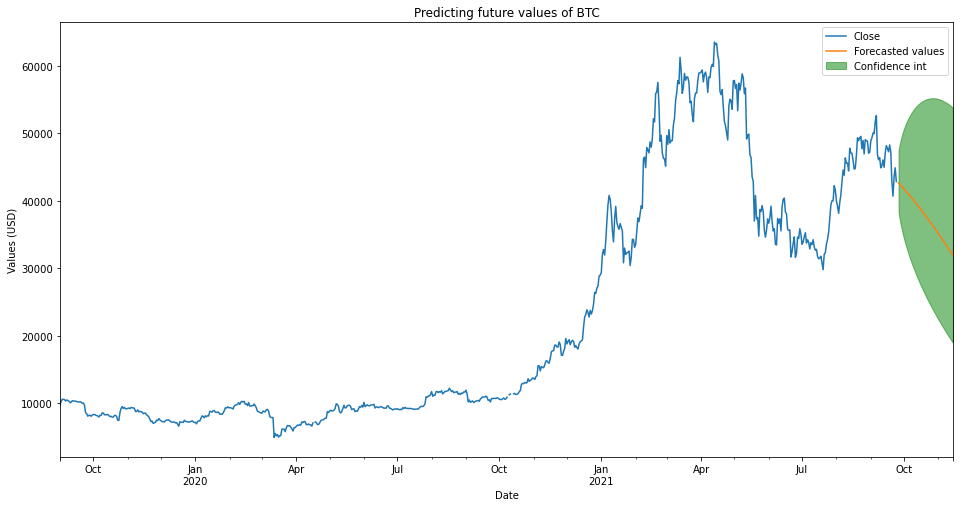

In [180]:
# Plotting the prices up to the most recent
ax = np.exp(bc_log).plot(label='Actual', figsize=(16,8))

# Plottting the forecast
pred_fut.plot(ax=ax, label='Forecasted values')

# Adding confidence area
plt.fill_between(pred_conf.index, 
                 pred_conf.iloc[:,0], 
                 pred_conf.iloc[:,1], 
                 color='g',alpha=.5, label='Confidence int')
plt.legend()
plt.title('Predicting future values of BTC')
plt.ylabel('Values (USD)')
plt.show()